# Optical Networking Gym: An Open-Source Toolkit for Resource Assignment Problems in Optical Networks

File processing the results of the experiments.

In [3]:
import itertools
import os
import pickle

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.rcParams.get("font.size")
plt.rcParams.update({'font.size': 14})

In [4]:
topology_name = "nobel-eu"
# topology_name = "janos-us"
# topology_name = "germany50"
strategies = np.arange(1, 5)

launch_powers = np.linspace(-8, 8, 9)

if topology_name == "nobel-eu":
    load = 210
    loads = np.arange(50, 651, 50)
elif topology_name == "germany50":
    load = 400
    loads = np.arange(300, 801, 50)
elif topology_name == "janos-us":
    load = 150
    loads = np.arange(100, 601, 50)

bandwidth = 4e12
frequency_start = 3e8 / 1565e-9
frequency_end = frequency_start + bandwidth
frequency_slot_bandwidth = 12.5e9
bit_rates = np.array((10, 40, 100, 400), dtype=np.int16)

markers = ("o", ">", "s", "<", "^", "v")
heuristics = ["KSP-FF-BM", "LS-BM-KSP", "BM-KSP-LB", "KSP-LB-BM"]

## Plots for the topology

In [5]:
# with open(
#     os.path.join(
#         "..",
#         # "examples", 
#         "topologies", f"{topology_name}.xml"
#         # "examples", "topologies", "nobel-us_gn_5-paths_6-modulations.h5"
#         # "examples", "topologies", "nobel-eu_gn_5-paths_6-modulations.h5"
#         # "examples", "topologies", "janos-us_gn_5-paths_6-modulations.h5"
#         # "examples", "topologies", "nsfnet_chen_gn_5-paths_6-modulations.h5"
#     ), "rb"
# ) as f:
#     topology = pickle.load(f)
from typing import Tuple
from optical_networking_gym.topology import Modulation, get_topology

topology_path = os.path.join(
        "..",
        # "examples", 
        "topologies", f"{topology_name}.xml")
def define_modulations() -> Tuple[Modulation, ...]:
    return (
        Modulation(
            name="BPSK",
            maximum_length=100_000,
            spectral_efficiency=1,
            minimum_osnr=12.6,
            inband_xt=-14,
        ),
        Modulation(
            name="QPSK",
            maximum_length=2_000,
            spectral_efficiency=2,
            minimum_osnr=12.6,
            inband_xt=-17,
        ),
        Modulation(
            name="8QAM",
            maximum_length=1_000,
            spectral_efficiency=3,
            minimum_osnr=18.6,
            inband_xt=-20,
        ),
        Modulation(
            name="16QAM",
            maximum_length=500,
            spectral_efficiency=4,
            minimum_osnr=22.4,
            inband_xt=-23,
        ),
        Modulation(
            name="32QAM",
            maximum_length=250,
            spectral_efficiency=5,
            minimum_osnr=26.4,
            inband_xt=-26,
        ),
        Modulation(
            name="64QAM",
            maximum_length=125,
            spectral_efficiency=6,
            minimum_osnr=30.4,
            inband_xt=-29,
        ),
    )

cur_modulations = define_modulations()

topology = get_topology(
    topology_path,
    topology_name,
    cur_modulations,
    80,
    0.2,
    4.5,
    5
)

In [6]:
print("nodes:", topology.number_of_nodes(), topology.number_of_nodes()*(topology.number_of_nodes()-1) // 2)
print("edges:", topology.number_of_edges())

nodes: 28 378
edges: 41


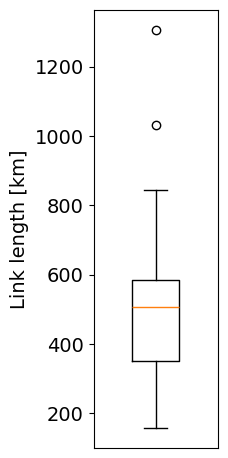

In [7]:
plt.figure(figsize=(2.5, 4.8))
plt.boxplot([topology[x][y]["length"] for x, y in topology.edges()])
plt.ylabel("Link length [km]")
plt.xticks([], [])
plt.xlim([0.8, 1.2])
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_topo_link_length.png")
# plt.savefig(f"figures/{topology_name}_topo_link_length.pdf")
# plt.savefig(f"figures/{topology_name}_topo_link_length.svg")
plt.show()

In [8]:
# for path in topology.graph["ksp"]["Athens", "Glasgow"]:
#     print(path)

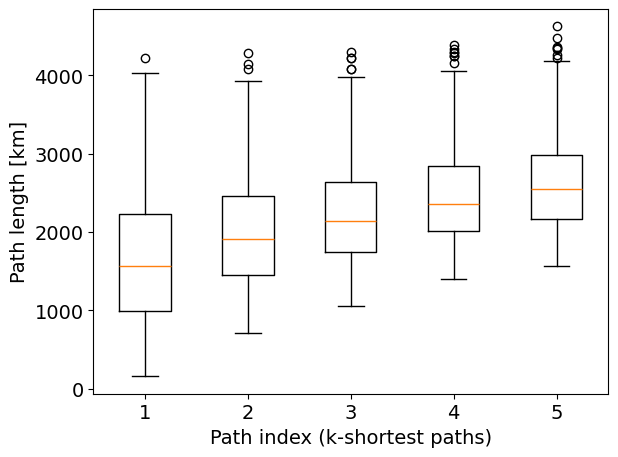

In [9]:
path_lengths = []
for k in range(topology.graph["k_paths"]):
    path_lengths.append([topology.graph["ksp"][x, y][k].length for x, y in itertools.combinations(topology.nodes(), 2)])
plt.figure()
plt.boxplot(path_lengths)
plt.xlabel("Path index (k-shortest paths)")
plt.ylabel("Path length [km]")
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_topo_path_length.png")
# plt.savefig(f"figures/{topology_name}_topo_path_length.pdf")
# plt.savefig(f"figures/{topology_name}_topo_path_length.svg")
plt.show()

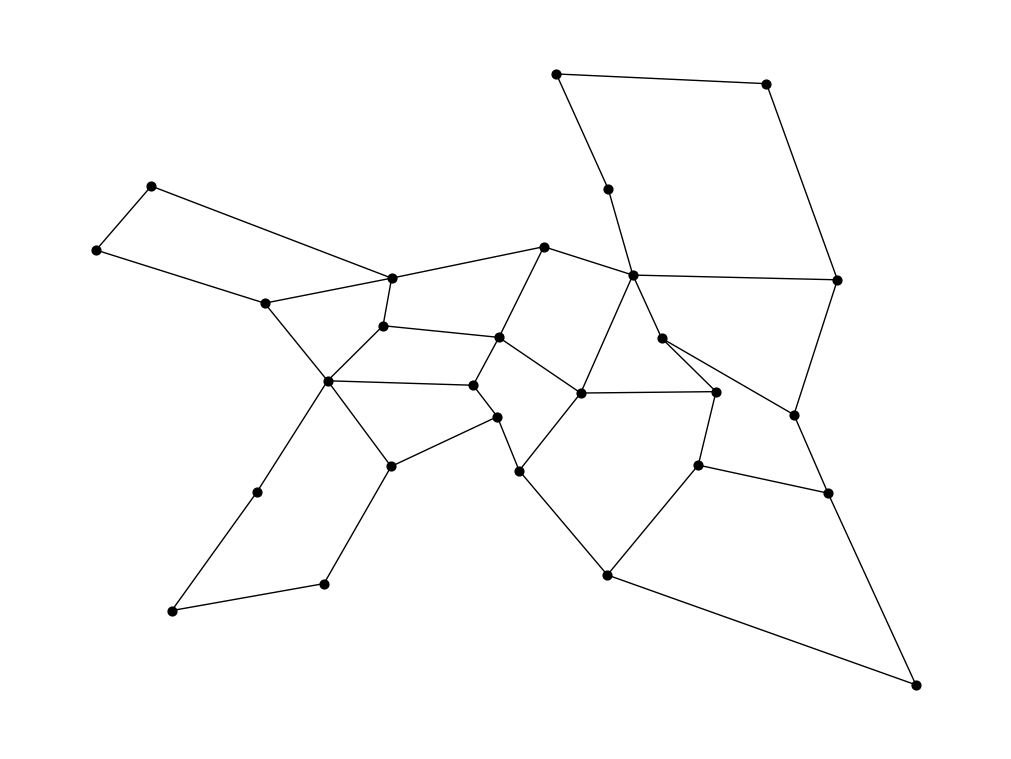

In [10]:
pos = nx.get_node_attributes(topology, "pos")
labels = {x: f"{y:.0f}" for x, y in nx.get_edge_attributes(topology, "length").items()}
plt.figure(figsize=(12.8, 9.6))

nx.draw_networkx_nodes(topology, pos=pos, node_color="black", node_size=40)
# nx.draw_networkx_labels(topology, pos={x: (y[0], y[1]-0.5) for x, y in pos.items()}, labels={x: x for x in topology.nodes()}, font_color="blue")

nx.draw_networkx_edges(topology, pos=pos)
# nx.draw_networkx_edge_labels(topology, pos=pos, edge_labels=labels, font_size=12, rotate=False)
plt.axis('off')
# plt.savefig(f"figures/{topology_name}_topo.png")
# plt.savefig(f"figures/{topology_name}_topo.pdf")
# plt.savefig(f"figures/{topology_name}_topo.svg")
plt.show()

## Plots for the launch power

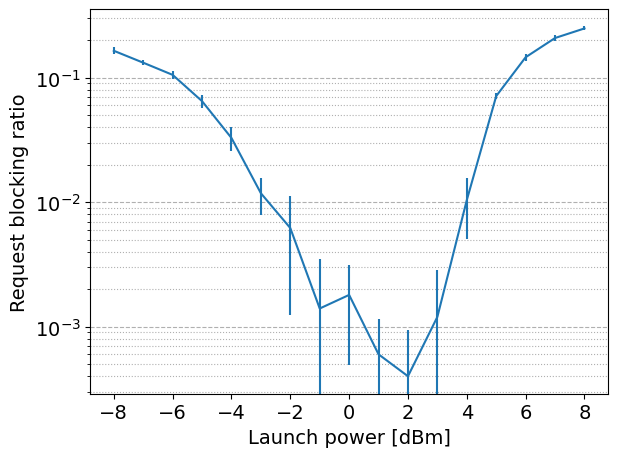

In [31]:
means = []
stdevs = []
topology_name = "nobel-eu"
load = 210.0
launch_powers = np.linspace(-8, 8, 17)
for launch_power in launch_powers:
    data_episodes = pd.read_csv(f"results/simulation_updteded_th_results_{topology_name}_{launch_power}_{load}.csv", skiprows=1)
    means.append(data_episodes["episode_service_blocking_rate"].mean())
    stdevs.append(data_episodes["episode_service_blocking_rate"].std())

plt.figure()
plt.errorbar(launch_powers, means, stdevs)
plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
# plt.grid(visible=True, which="major", axis="x", ls=":")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.xlabel("Launch power [dBm]")
plt.ylabel("Request blocking ratio")
plt.xticks(range(-8, 9, 2))
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_lp_rbr.png")
# plt.savefig(f"figures/{topology_name}_lp_rbr.pdf")
# plt.savefig(f"figures/{topology_name}_lp_rbr.svg")
plt.show()

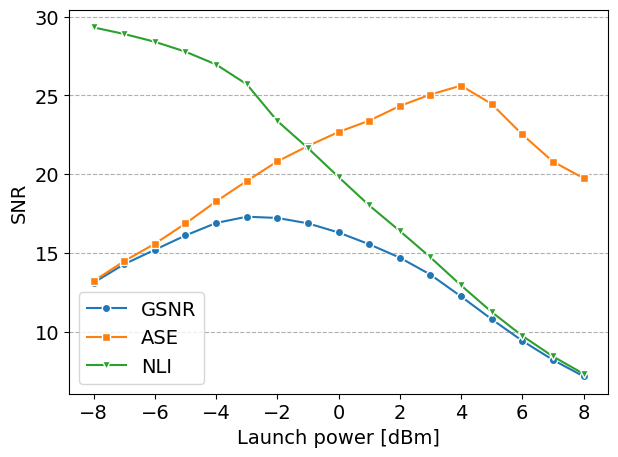

In [34]:
mean_osnr = []
stdev_osnr = []
mean_ase = []
stdev_ase = []
mean_nli = []
stdev_nli = []
disrupted_services = []
best_launch_power = 0
best_mean = 0

for launch_power in launch_powers:
    data_services = pd.read_csv(f"results/lp_services_1_{topology_name}_{launch_power}_{load}_20.csv", skiprows=1)

    mean = data_services["osnr"].mean()

    if mean > best_mean:
        best_mean = mean
        best_launch_power = launch_power

    mean_osnr.append(mean)
    stdev_osnr.append(data_services["osnr"].std())

    mean_ase.append(data_services["ase"].mean())
    stdev_ase.append(data_services["ase"].std())

    mean_nli.append(data_services["nli"].mean())
    stdev_nli.append(data_services["nli"].std())

    data_episodes = pd.read_csv(f"results/simulation_updteded_th_results_{topology_name}_{launch_power}_{load}.csv", skiprows=1)
    disrupted_services.append(data_episodes["episode_disrupted_services"].sum())

plt.figure()

# plt.errorbar(launch_powers, mean_osnr, stdev_osnr, label="GSNR")
# plt.errorbar(launch_powers, mean_ase, stdev_ase, label="ASE")
# plt.errorbar(launch_powers, mean_nli, stdev_nli, label="NLI")

plt.plot(launch_powers, mean_osnr, label="GSNR", marker="o", mec="white")
plt.plot(launch_powers, mean_ase, label="ASE", marker="s", mec="white")
plt.plot(launch_powers, mean_nli, label="NLI", marker="v", mec="white")

plt.grid(visible=True, which="major", axis="y", ls="--")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.xlabel("Launch power [dBm]")
plt.ylabel("SNR")
plt.legend()
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_lp_snr.png")
# plt.savefig(f"figures/{topology_name}_lp_snr.pdf")
# plt.savefig(f"figures/{topology_name}_lp_snr.svg")
plt.show()

### Launch power service statistics

In [42]:
data_services = pd.read_csv(f"results/lp_services_1_{topology_name}_{best_launch_power}_{load}_20.csv", skiprows=1)
data_services.describe()

,id,source,destination,bit_rate,path_k,path_length,modulation,min_osnr,osnr,ase,nli,disrupted_services
count,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000,4995.000000
mean,499.000000,13.537137,13.432833,139.693694,4.929129,1578.608141,4.810811,15.565514,17.299862,19.565779,25.713819,0.065065
std,288.415187,8.051097,8.104620,156.303945,0.648295,826.390496,1.305100,3.839317,4.468261,5.501085,7.228528,0.313191
min,0.000000,0.000000,0.000000,10.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,249.000000,7.000000,6.000000,40.000000,5.000000,935.555000,4.000000,13.240000,15.457331,17.202018,20.686059,0.000000
50%,499.000000,13.000000,13.000000,100.000000,5.000000,1480.004000,5.000000,16.160000,17.702362,20.550684,23.953141,0.000000
75%,749.000000,21.000000,20.000000,400.000000,5.000000,2119.935000,6.000000,19.010000,19.927510,23.189907,32.342293,0.000000
max,998.000000,27.000000,27.000000,400.000000,5.000000,4227.992000,6.000000,19.010000,31.253490,33.101415,42.365707,3.000000


In [43]:
accepted = data_services[(data_services["path_k"] != -1)]
accepted["margin"] = accepted.apply(lambda x: x.osnr - x.min_osnr, axis=1)
accepted = accepted.drop(["id", "source", "destination"], axis=1)
accepted.describe()

C:\Users\talle\AppData\Local\Temp\ipykernel_9672\740029016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted["margin"] = accepted.apply(lambda x: x.osnr - x.min_osnr, axis=1)


,bit_rate,path_k,path_length,modulation,min_osnr,osnr,ase,nli,disrupted_services,margin
count,4936.000000,4936.0,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000
mean,136.582253,5.0,1597.489195,4.880267,15.763521,17.518600,19.811602,26.033129,0.077796,1.755079
std,154.606696,0.0,812.956695,1.146797,3.405379,4.019018,5.050419,6.651512,0.292468,1.487840
min,10.000000,5.0,157.685000,2.000000,6.720000,6.742415,6.747772,14.812436,0.000000,0.000230
25%,40.000000,5.0,953.976000,4.000000,13.240000,15.560023,17.421708,20.797314,0.000000,0.683918
50%,40.000000,5.0,1507.056000,5.000000,16.160000,17.760951,20.570037,24.044083,0.000000,1.508160
75%,100.000000,5.0,2138.584000,6.000000,19.010000,19.973527,23.208049,33.246102,0.000000,2.330100
max,400.000000,5.0,4227.992000,6.000000,19.010000,31.253490,33.101415,42.365707,3.000000,12.243490


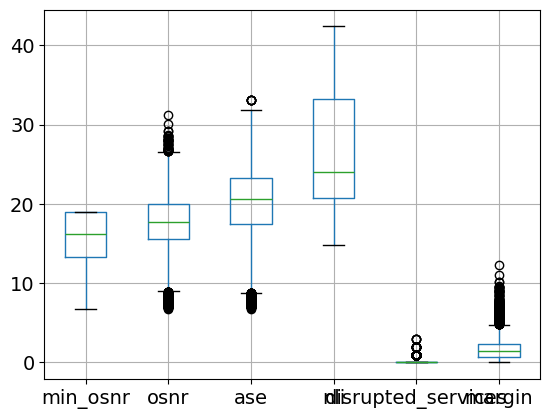

In [44]:
accepted.drop(["path_k", "path_length", "bit_rate", "modulation"], axis=1).boxplot()
plt.show()

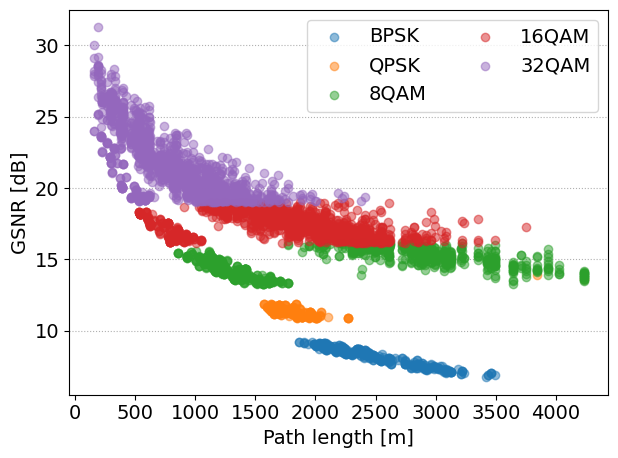

In [46]:
plt.figure()

for modulation in sorted(accepted["modulation"].unique()):
    plt.scatter(accepted[(accepted["modulation"] == modulation)]["path_length"], accepted[(accepted["modulation"] == modulation)]["osnr"], label=modulation, zorder=modulation + 1, alpha=0.5, edgecolors=None)
plt.legend(loc=0, ncols=2, labels=("BPSK", "QPSK", "8QAM", "16QAM", "32QAM", "64QAM"))
plt.xlabel("Path length [m]")
plt.ylabel("GSNR [dB]")
plt.grid(which="major", axis="y", ls=":", zorder=0)
plt.tight_layout()
# plt.savefig(f"figures/{topology_name}_lp_gsnr_length.png")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_length.pdf")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_length.svg")
plt.show()

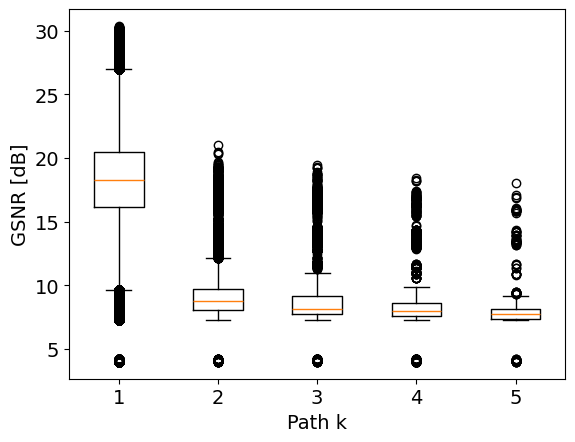

In [15]:
plt.figure()
gsnr = []
for k in range(accepted["path_k"].max()+1):
    gsnr.append(accepted[(accepted["path_k"] == k)]["osnr"].to_numpy())
# plt.scatter(accepted["path_k"], accepted["osnr"])
plt.boxplot(gsnr)
plt.xlabel("Path k")
plt.ylabel("GSNR [dB]")
plt.savefig(f"figures/{topology_name}_lp_gsnr_k_path.png")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_k_path.pdf")
# plt.savefig(f"figures/{topology_name}_lp_gsnr_k_path.svg")
plt.show()

### Launch power for a certain service

## Plots for impact of margin

In [16]:
data_services = pd.read_csv(f"results/mr_services_1_0.0_{topology_name.upper()}_{best_launch_power}_{load}_10.csv", skiprows=1)
# data_services = pd.read_csv(f"results/mr_services_1_0.0_{topology_name.upper()}_-4.0_{load}_10.csv", skiprows=1)
# data_services.describe()
accepted = data_services[(data_services["path_k"] != -1)]
accepted["margin"] = accepted.apply(lambda x: x.osnr - x.min_osnr, axis=1)
# accepted = accepted.drop(["id", "source", "destination"], axis=1)
accepted.describe()

FileNotFoundError: [Errno 2] No such file or directory: 'results/mr_services_1_0.0_NOBEL-EU_-4.0_210_10.csv'

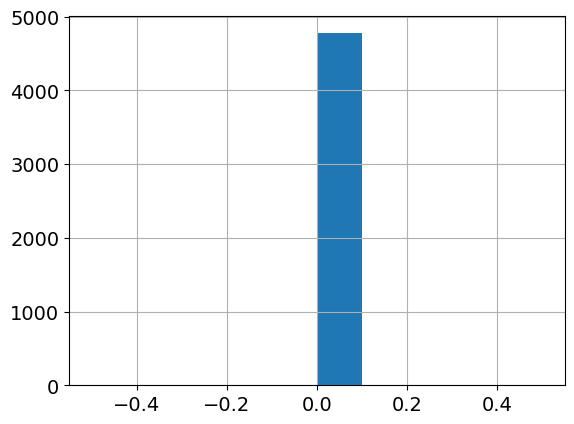

In [90]:
accepted["disrupted_services"].hist()
plt.show()

In [91]:
# data_episodes = pd.read_csv(f"results/mr_episodes_1_0.0_{topology_name.upper()}_{best_launch_power}_{load}.csv", skiprows=1)
data_episodes = pd.read_csv(f"results/mr_episodes_1_0.0_{topology_name.upper()}_-4.0_{load}.csv", skiprows=1)
data_episodes["episode_disrupted_services"]

0    0
1    0
2    0
3    0
4    0
Name: episode_disrupted_services, dtype: int64

## Plots about dataset generation

In [93]:
with open(f"results/ds_episodes_{1}_{topology_name.upper()}_{int(best_launch_power)}_{load}.pkl", "rb") as file:
    dataset = pickle.load(file)

## Plots loads

In [67]:
data_loads = None
for strategy in strategies:
    for load in loads:
        if data_loads is None:
            data_loads = pd.read_csv(f"results/load_episodes_{strategy}_{topology_name.upper()}_{best_launch_power}_{load}.csv", skiprows=1)
            data_loads["strategy"] = strategy
            data_loads["load"] = load
        else:
            data_load = pd.read_csv(f"results/load_episodes_{strategy}_{topology_name.upper()}_{best_launch_power}_{load}.csv", skiprows=1)
            data_load["strategy"] = strategy
            data_load["load"] = load
            data_loads = pd.concat([data_loads, data_load], axis=0, ignore_index=True)
data_loads.head()

,episode,service_blocking_rate,episode_service_blocking_rate,bit_rate_blocking_rate,episode_bit_rate_blocking_rate,modulation_1,modulation_2,modulation_3,modulation_4,modulation_5,modulation_6,episode_disrupted_services,episode_time,strategy,load
0,0,0.026000,0.025025,0.074272,0.074272,11,91,93,385,262,132,0,3.67,1,50
1,1,0.026013,0.026026,0.076585,0.078949,9,100,96,381,257,130,0,2.70,1,50
2,2,0.029019,0.035035,0.087007,0.108527,12,89,89,376,252,146,0,2.58,1,50
3,3,0.029272,0.030030,0.087437,0.088692,11,114,107,322,259,156,0,3.12,1,50
4,4,0.031025,0.038038,0.092844,0.114449,15,95,94,351,265,141,0,2.55,1,50


In [68]:
data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()

,episode,service_blocking_rate,episode_service_blocking_rate,bit_rate_blocking_rate,episode_bit_rate_blocking_rate,modulation_1,modulation_2,modulation_3,modulation_4,modulation_5,modulation_6,episode_disrupted_services,episode_time,strategy
load,,,,,,,,,,,,,,
50,499.5,0.032058,0.032158,0.093539,0.093740,10.673,101.364,104.301,352.746,257.366,140.424,0.0,2.82395,4.0
100,499.5,0.033606,0.033657,0.098059,0.098095,9.766,101.544,105.616,351.533,256.747,140.171,0.0,4.32062,4.0
150,499.5,0.040785,0.040924,0.118983,0.119193,6.134,99.509,105.644,350.829,255.989,140.012,0.0,5.57204,4.0
200,499.5,0.056949,0.057279,0.165858,0.166544,3.141,89.575,104.012,349.823,255.399,139.828,0.0,6.47238,4.0
250,499.5,0.077819,0.078492,0.225448,0.227096,1.695,75.178,100.989,348.412,254.752,139.560,0.0,7.03335,4.0
300,499.5,0.100867,0.101554,0.288946,0.290535,1.126,60.039,96.814,346.059,254.197,139.313,0.0,7.33839,4.0
350,499.5,0.123035,0.123418,0.346392,0.347616,0.711,47.152,92.279,343.216,253.352,138.995,0.0,7.53249,4.0
400,499.5,0.144616,0.145175,0.396778,0.398819,0.456,36.642,86.272,339.710,252.147,138.743,0.0,7.64897,4.0
450,499.5,0.165753,0.166368,0.441382,0.443032,0.297,28.342,79.858,335.320,250.669,138.312,0.0,7.80029,4.0


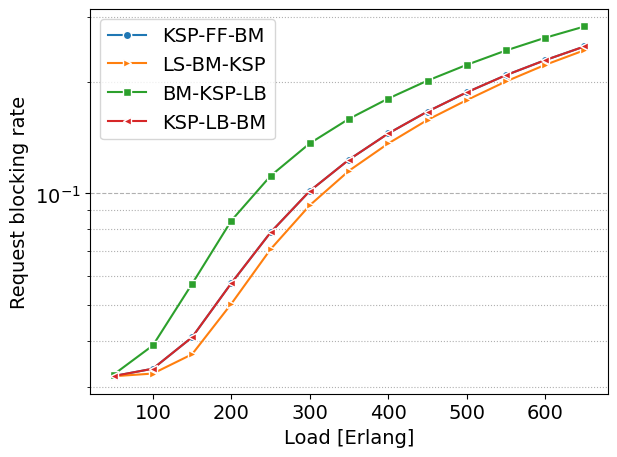

In [69]:
plt.figure()
for ids, strategy in enumerate(strategies):
    # plt.errorbar(
    #     loads,
    #     data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"],
    #     data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_service_blocking_rate"],
    #     label=strategy, #marker="x"
    # )
    plt.plot(
        loads,
        data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"],
        # data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_service_blocking_rate"],
        label=strategy,
        marker=markers[ids],
        mec="white",
    )
    # print(strategy, data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"])

plt.xlabel("Load [Erlang]")
plt.ylabel("Request blocking rate")
plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.legend(labels=heuristics)
plt.tight_layout()
plt.savefig(f"figures/{topology_name}_load_rbr.png")
plt.savefig(f"figures/{topology_name}_load_rbr.pdf")
# plt.savefig(f"figures/{topology_name}_load_rbr.svg")
plt.show()

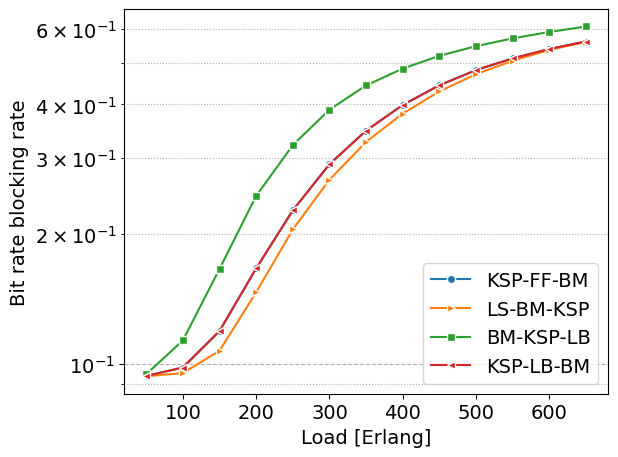

In [70]:
plt.figure()
for ids, strategy in enumerate(strategies):
    plt.plot(
        # loads,
        data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_bit_rate_blocking_rate"],
        # data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_bit_rate_blocking_rate"],
        label=strategy,
        marker=markers[ids],
        mec="white",
    )

plt.xlabel("Load [Erlang]")
plt.ylabel("Bit rate blocking rate")
plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.legend(labels=heuristics)
plt.tight_layout()
plt.savefig(f"figures/{topology_name}_load_brbr.png")
plt.savefig(f"figures/{topology_name}_load_brbr.pdf")
# plt.savefig(f"figures/{topology_name}_load_brbr.svg")
plt.show()

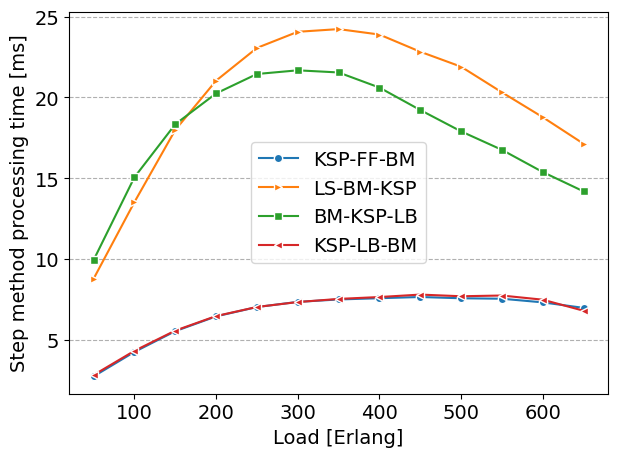

In [71]:
plt.figure()
for ids, strategy in enumerate(strategies):
    # plt.errorbar(
    #     loads,
    #     data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"],
    #     data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_service_blocking_rate"],
    #     label=strategy, #marker="x"
    # )
    plt.plot(
        loads,
        data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_time"],
        # data_loads[(data_loads["strategy"] == strategy)].groupby("load").std()["episode_service_blocking_rate"],
        label=strategy,
        marker=markers[ids],
        mec="white",
    )
    # print(strategy, data_loads[(data_loads["strategy"] == strategy)].groupby("load").mean()["episode_service_blocking_rate"])

plt.xlabel("Load [Erlang]")
plt.ylabel("Step method processing time [ms]")
# plt.gca().set_yscale("log")
plt.grid(visible=True, which="major", axis="y", ls="--")
plt.grid(visible=True, which="minor", axis="y", ls=":")
plt.legend(labels=heuristics)
plt.tight_layout()
plt.savefig(f"figures/{topology_name}_load_step_time.png")
plt.savefig(f"figures/{topology_name}_load_step_time.pdf")
# plt.savefig(f"figures/{topology_name}_load_rbr.svg")
plt.show()